In [178]:
import re
import datetime
import urllib.request
import io
import math
from datetime import date
import json

import torch
from Bio import Phylo
import pandas as pd
import matplotlib.pyplot as plt
from augur.utils import json_to_tree

import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel
from pyro.contrib.epidemiology.models import SuperspreadingSEIRModel
from pyro.contrib.epidemiology.distributions import binomial_dist, infection_dist

pyro.enable_validation(True)
torch.set_default_dtype(torch.double)
torch.set_printoptions(precision=2)
print(torch.__version__)
print(pyro.__version__)

1.6.0
1.4.0


# Information Parsing
<hr>

### Parse timetree phylogeny and find clades

In [180]:
# with auspice JSONs

region = "california"
tree_json = f"/home/phoenix/code/nf-epigen/jsons/ncov_{region}.json"

with open(tree_json) as f:
        tree = json.load(f)
        
phylogeny = json_to_tree(tree)

In [ ]:
# with newicks


In [162]:
# Fix a parsing error for whereby internal nodes interpret .name as .confidence
for clade in phylogeny.find_clades():
    if clade.confidence:
        clade.name = clade.confidence
        clade.confidence = None

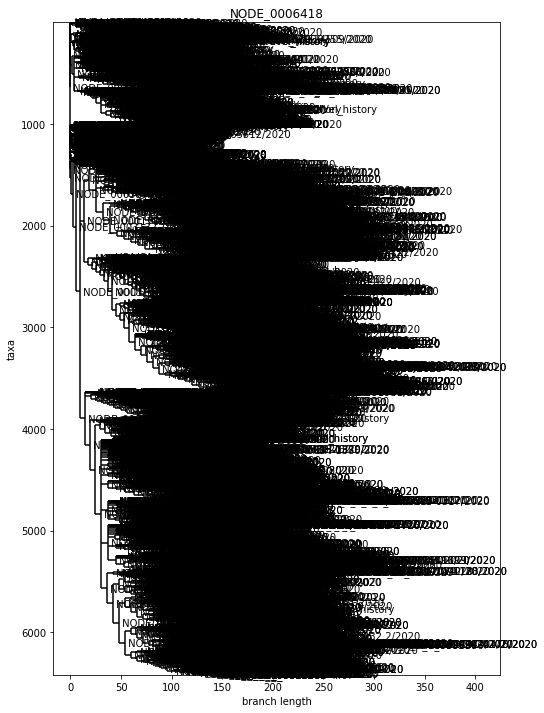

In [163]:
Phylo.draw(phylogeny, do_show=False)
plt.gcf().set_figwidth(8)
plt.gcf().set_figheight(12)

In [165]:
timeseries_path =f"/home/phoenix/code/nf-epigen/results/timeseries_cleaned/summary_{region}_timeseries_new_cases.tsv"
df = pd.read_csv(timeseries_path, sep="\t")
print(len(df))
df.head()

224


,date,new_cases
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,2


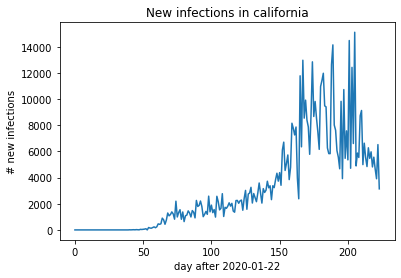

In [166]:
plt.plot(df["new_cases"])
plt.xlabel("day after {}".format(df["date"][0]))
plt.ylabel("# new infections")
plt.title("New infections in {}".format(region));

# Converting data inputs to PyTorch tensors

In [167]:
start_date = datetime.datetime.strptime(df.date[0], "%Y-%m-%d")
start_date

datetime.datetime(2020, 1, 22, 0, 0)

In [168]:
new_cases = list(df["new_cases"])
if new_cases[-1] == 0:
    new_cases.pop(-1)
new_cases = torch.tensor(new_cases, dtype=torch.double)
print(new_cases.sum())

tensor(715617.)


In [169]:
import time as t
import datetime as dt

leaf_times = []
coal_times = []

def is_leap_year(year):
    # modified from https://github.com/nextstrain/auspice/blob/e05507873bbab1b5327302f8436edb5cf119b725/src/util/dateHelpers.js#L9
    if ((year % 4 == 0) and (year % 100 != 0)) or (year % 400 == 0):
        return True

def time_from_branch_length(num_date):
    
    frac_part = math.modf(num_date)[0] 
    year = math.modf(num_date)[1]
    
    if is_leap_year(year):
        n_days_in_year = 366
    else:
        n_days_in_year = 365
        
    n_days = float(frac_part) * int(n_days_in_year)
    year_begin = dt.datetime(int(year), 1, 1)
    year_mil = t.mktime(year_begin.timetuple())*1000
    year_plus_days = year_mil + n_days*24*60*60*1000
    return year_plus_days/1000.0
    #return datetime.datetime.fromtimestamp(year_plus_days/1000.0)

for clade in phylogeny.find_clades():
    date = clade.node_attrs["num_date"]["value"]
    time = time_from_branch_length(date)

    num_children = len(clade)
    if num_children == 0:
        leaf_times.append(time)
    else:
        # Pyro expects binary coalescent events, so we split n-ary events
        # into n-1 separate binary events.
        for _ in range(num_children - 1):
            coal_times.append(time)
            
assert len(leaf_times) == 1 + len(coal_times)

leaf_times = torch.tensor(leaf_times, dtype=torch.double)
coal_times = torch.tensor(coal_times, dtype=torch.double)

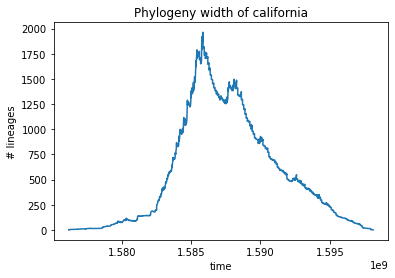

In [170]:
times = torch.cat([coal_times, leaf_times])
signs = torch.cat([-torch.ones_like(coal_times), torch.ones_like(leaf_times)])
times, index = times.sort(0)
signs = signs[index]
lineages = signs.flip([0]).cumsum(0).flip([0])

plt.plot(times, lineages)
plt.xlabel("time")
plt.ylabel("# lineages")
plt.title("Phylogeny width of {}".format(region));

In [173]:
model = SuperspreadingSEIRModel(population=int(1e6),
                                incubation_time=5.5,
                                recovery_time=14.,
                                data=new_cases,
                                leaf_times=leaf_times,
                                coal_times=coal_times)

mcmc = model.fit_mcmc(num_samples=200,
                 haar_full_mass=7)

INFO 	 Running inference...
Sample: 100%|██████████| 400/400 [01:49,  3.67it/s, step size=8.25e-04, acc. prob=0.892]


In [174]:
mcmc.summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
              R0      0.25      0.00      0.25      0.24      0.25      2.61      2.51
               k      2.74      0.09      2.76      2.60      2.89      2.61      2.40
             rho      0.57      0.00      0.57      0.57      0.57      2.92      2.33
  auxiliary[0,0] 999996.48      0.00 999996.48 999996.48 999996.49      3.06      2.57
  auxiliary[0,1] 999997.27      0.00 999997.27 999997.27 999997.27      4.08      1.84
  auxiliary[0,2] 999996.54      0.01 999996.53 999996.53 999996.55      3.19      1.74
  auxiliary[0,3] 999996.33      0.01 999996.33 999996.33 999996.34      3.04      2.13
  auxiliary[0,4] 999994.01      0.01 999994.01 999993.99 999994.02      2.94      2.06
  auxiliary[0,5] 999993.09      0.01 999993.09 999993.08 999993.10      3.54      1.71
  auxiliary[0,6] 999992.62      0.01 999992.62 999992.61 999992.63      4.84      1.00
  auxiliary[0,7] 999992.54      0.00 99999

In [175]:
import os
os.getcwd()

'/home/phoenix/code/nf-epigen/exploration'